# **Deploy a model in the cloud**

**Abstract :** 

The very young AgriTech start-up, named "Fruits!", seeks to offer innovative solutions for fruit harvesting.

The company's desire is to preserve fruit biodiversity by allowing specific treatments for each fruit species by developing intelligent picking robots.

This start-up initially wants to make itself known by providing the general public with a mobile application that would allow users to take a picture of a fruit and obtain information on this fruit.

For the start-up, this application would make the general public aware of fruit biodiversity and set up a first version of the fruit image classification engine.

In addition, the development of the mobile application will make it possible to build a first version of the necessary Big Data architecture.

We are therefore in charge of developing in a Big Data environment a first data processing chain which will include preprocessing and a dimension reduction step. 

We will have to take into account in our developments the fact that the volume of data will increase very quickly after the delivery of this project. We will therefore develop scripts in Pyspark and use the AWS cloud to take advantage of a Big Data architecture (EC2, S3, EMR), based on an EC2 Linux server.

**Summary :** 

I. Deployment of the solution locally

  I.1. Librairies Import

  I.2. Defining PATHs

  I.3. Creating the SparkSession

  I.4. Data processing

  I.5. Loading saved data and vaidating the result

II. Deployment of the solution in the cloud

  II.1. Technical choices 

  II.2. Setting up the working environment

  II.3. Upload data to S3 

  II.4. Configuring the EMR server and creating the cluster 

  II.5. Creating the SSH tunnel to the EC2 instance (Master)

  II.6. Code execution

  II.6.1. Starting the Spark session

  II.6.3. Import of Librairies

  II.6.3. Defining PATHs 

  II.6.4. Data processing

  II.6.5. Saving results

**Bibliography :**

Install Spark : https://computingforgeeks.com/how-to-install-apache-spark-on-ubuntu-debian/

Pyspark : https://datascientest.com/pyspark

Spark Session : https://www.veonum.com/apache-spark-pour-les-nuls/

PyArrow :https://blog.clairvoyantsoft.com/optimizing-conversion-between-spark-and-pandas-dataframes-using-apache-pyarrow-9d439cbf2010

MobileNetV2 : https://towardsdatascience.com/review-mobilenetv2-light-weight-model-image-classification-8febb490e61c

Instances M5 Amazon EC2 : https://aws.amazon.com/fr/ec2/instance-types/m5/

https://docs.databricks.com/applications/machine-learning/preprocess-data/transfer-learning-tensorflow.html


**Goals :**

1. Develop an initial data processing chain that will include preprocessing and a dimension reduction step.
2. Take into account that the volume of data will increase very soon after the delivery of this project, which involves:
. Deploy data processing in a Big Data environment
. Develop scripts in pyspark to perform distributed computing



# **I. Deployment of the solution locally**

### **I.1. librairies Import**

In [1]:
!pip install Pandas pillow tensorflow pyspark pyarrow # packages
import pandas as pd
from PIL import Image
import numpy as np
import io
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

# Keras 
import keras
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, load_img 
from tensorflow.keras import Model
from pyspark.sql.functions import col, pandas_udf, PandasUDFType
from pyspark.sql.functions import  element_at, split
from pyspark.sql import SparkSession

# Image processing
import cv2 
from matplotlib.pyplot import imread
from IPython.display import Image
from scipy.ndimage import gaussian_filter
from PIL import Image as Image_PIL
from PIL import Image, ImageOps
from PIL import ImageFilter
from PIL import Image as PImage
import matplotlib.image as mpimg
!pip install opencv-contrib-python

# Size reduction 
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Versions
print('\n____Version des librairies utilisées____ :\n')


print('NumPy                 : ' + np.version.full_version)
print('Pandas                : ' + pd.__version__)
print('Seaborn               : ' + sns.__version__)
print('tensorflow            : ' + tf.__version__)
print('keras                 : ' + keras.__version__)


     |████████████████████████████████| 281.4 MB 32 kB/s 
     |████████████████████████████████| 462 kB 51.8 MB/s 
     |████████████████████████████████| 198 kB 40.0 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=b8b32117f3201d00352aaf2425575902e1db141724609d352604d99597985537
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark

____Version des librairies utilisées____ :

NumPy                 : 1.21.6
Pandas                : 1.3.5
Seaborn               : 0.11.2
tensorflow            : 2.8.0
keras                 : 2.8.0


### **I.2. Defining PATHs **

In this local version we will use an extract of images 'Training' to be processed in this
first local version.


In [2]:
PATH = os.getcwd() # Absolute path of the working directory where Python is
                   # currently running as a string str
PATH_Data = PATH+'/drive/MyDrive/images_p8/training'
PATH_Result = PATH+'/drive/MyDrive/Results'
print('PATH:        '+\
      PATH+'\nPATH_Data:   '+\
      PATH_Data+'\nPATH_Result: '+PATH_Result)

PATH:        /content
PATH_Data:   /content/drive/MyDrive/images_p8/training
PATH_Result: /content/drive/MyDrive/Results


### **I.3. Creating the SparkSession**

The project statement requires us to develop scripts in pyspark
in order to take into account the very rapid increase in volume
of given after the delivery of the project.

**PySpark** est un moyen de communiquer avec Spark via le langage Python.
**Spark**, quant à lui, est un outil qui permet de gérer et de coordonner
l'exécution de tâches sur des données à travers un groupe d'ordinateurs.
Spark (ou Apache Spark) est un framework open source de calcul distribué
in-memory pour le traitement et l'analyse de données massives.

The Spark application is controlled through a driver process called SparkSession.
An instance of **SparkSession** is how Spark executes user-defined functions
across the cluster. A SparkSession always corresponds to a Spark application.

In [3]:
# Create a spark session:
spark = (SparkSession
             .builder
             .appName('P8') 
             .master('local')
             .config("spark.sql.parquet.writeLegacyFormat", 'true')
             .getOrCreate()
)

We also create the "sc" variable which is a SparkContext from the spark variable.
A SparkContext represents the connection to a Spark cluster, and can be used to create RDDs, accumulators and broadcast variables on that cluster. Only one SparkContext should be active per JVM


In [4]:
# Create the "sc" variable:
sc = spark.sparkContext

### **I.4. Data processing**

**I.4.1. Loading data and displaying a sample image**

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
images = spark.read.format("binaryFile") \
              .option("pathGlobFilter", "*.jpg") \
              .option("recursiveFileLookup", "true") \
              .load(PATH_Data)

In [8]:
# Display of the first 5 images
images = images.withColumn('label', element_at(split(images['path'], '/'),-2))
print(images.printSchema())
print(images.select('path','label').show(10,False))

root
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- content: binary (nullable = true)
 |-- label: string (nullable = true)

None
+----------------------------------------------------------------+------+
|path                                                            |label |
+----------------------------------------------------------------+------+
|file:/content/drive/MyDrive/images_p8/training/pear_1/r1_288.jpg|pear_1|
|file:/content/drive/MyDrive/images_p8/training/pear_1/r1_300.jpg|pear_1|
|file:/content/drive/MyDrive/images_p8/training/pear_1/r0_324.jpg|pear_1|
|file:/content/drive/MyDrive/images_p8/training/pear_1/r0_36.jpg |pear_1|
|file:/content/drive/MyDrive/images_p8/training/pear_1/r1_290.jpg|pear_1|
|file:/content/drive/MyDrive/images_p8/training/pear_1/r0_0.jpg  |pear_1|
|file:/content/drive/MyDrive/images_p8/training/pear_1/r1_276.jpg|pear_1|
|file:/content/drive/MyDrive/images_p8/training/pe

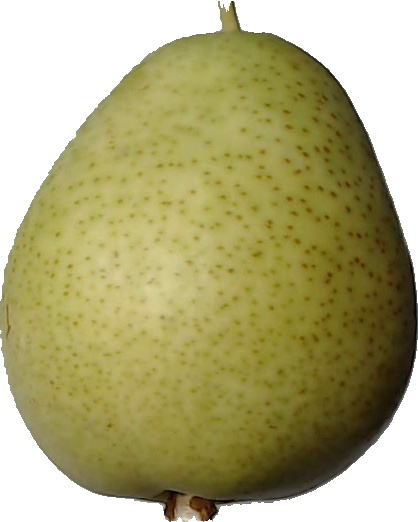

In [9]:
# View sample images
byteImgIO = io.BytesIO()
byteImg = Image.open("/content/drive/MyDrive/images_p8/training/pear_1/r0_104\
.jpg")
byteImg.save(byteImgIO, "PNG")
byteImgIO.seek(0)
byteImg = byteImgIO.read()
dataBytesIO = io.BytesIO(byteImg)
Image.open(dataBytesIO)

**I.4.2. Model preparation**

We will use the transfer learning technique to extract the features from the images.
We chose to use the MobileNetV2 because it is noted for excellent generalization performance with fewer error rates on recognition tasks compared to other models like VGG16 for example.

In [10]:
model = MobileNetV2(weights='imagenet',
                    include_top=True,
                    input_shape=(224, 224, 3))

14548992/14536120 [==============================] - 0s 0us/step


In [11]:
# There is a last layer which is used to classify the images
# according to 1000 categories that we don't want to use.
new_model = Model(inputs=model.input,
                  outputs=model.layers[-2].output)

new_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

All workers must be able to access the model and its weights.
A good practice consists in loading the model on the driver then to diffuse
then the weights to the different workers.

In [12]:
brodcast_weights = sc.broadcast(new_model.get_weights())

In [13]:
# Let's put this as a function:
def model_fn():
    """
    Returns a MobileNetV2 model with last layer removed 
    and broadcasted pretrained weights.
    """
    model = MobileNetV2(weights='imagenet',
                        include_top=True,
                        input_shape=(224, 224, 3))
    new_model = Model(inputs=model.input,
                      outputs=model.layers[-2].output)
    new_model.set_weights(brodcast_weights.value)
    return new_model

**I.4.3. Loading images and applying of their featurization through the use of pandas UDF**

In [14]:
def preprocess(content):
    """
    Preprocesses raw image bytes for prediction.
    """
    img = Image.open(io.BytesIO(content)).resize([224, 224])
    arr = img_to_array(img)
    return preprocess_input(arr) # scale input pixels 

def featurize_series(model, content_series):
    """
    Featurize a pd.Series of raw images using the input model.
    :return: a pd.Series of image features
    """
    input = np.stack(content_series.map(preprocess))
    preds = model.predict(input)
    # For some layers, output features will be multi-dimensional tensors.
    # We flatten the feature tensors to vectors for easier storage in Spark DataFrames.
    output = [p.flatten() for p in preds]
    return pd.Series(output)

@pandas_udf('array<float>', PandasUDFType.SCALAR_ITER)
def featurize_udf(content_series_iter):
    '''
    This method is a Scalar Iterator pandas UDF wrapping our featurization 
    function.
    The decorator specifies that this returns a Spark DataFrame column of type 
    ArrayType(FloatType).

    :param content_series_iter: This argument is an iterator over batches
     of data, where each batch is a pandas Series of image data.
    '''
    # With Scalar Iterator pandas UDFs, we can load the model once and then re-use it
    # for multiple data batches.  This amortizes the overhead of loading big models.
    model = model_fn()
    for content_series in content_series_iter:
        yield featurize_series(model, content_series)
        # yield, the code of the function body does not run. The function only returns the generator object

/usr/local/lib/python3.7/dist-packages/pyspark/sql/pandas/functions.py:392: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.
  "in the future releases. See SPARK-28264 for more details.", UserWarning)


In [15]:
features_df = images.repartition(20).select(col("path"),
                                            col("label"),
                                            featurize_udf("content").alias\
                                            ("features")
                                           )

In [16]:
# Recording of processed data in "parquet" format
features_df.write.mode("overwrite").parquet(PATH_Result)

### **I.5. Loading saved data and validating the result**

In [17]:
# We load the freshly recorded data into a Pandas DataFrame
df = pd.read_parquet(PATH_Result, engine='pyarrow')

In [18]:
df.head(5)

,path,label,features
0,file:/content/drive/MyDrive/images_p8/training...,pear_1,"[1.5605667, 0.051802725, 0.0, 0.0, 0.0, 0.0102..."
1,file:/content/drive/MyDrive/images_p8/training...,pear_1,"[1.6572809, 0.051905166, 0.0, 0.0, 0.0, 0.0136..."
2,file:/content/drive/MyDrive/images_p8/training...,pear_1,"[1.4443904, 0.06285586, 0.0, 0.0, 0.0, 0.03430..."
3,file:/content/drive/MyDrive/images_p8/training...,pear_1,"[0.84822416, 0.014547105, 0.0, 0.0, 0.0, 0.017..."
4,file:/content/drive/MyDrive/images_p8/training...,pear_1,"[0.6841974, 0.34653434, 0.0, 0.0, 0.0, 0.0, 1...."


In [19]:
df.loc[0,'features'].shape

(1280,)

In [20]:
my_feat = df['features'].tolist()

(1437, 43)


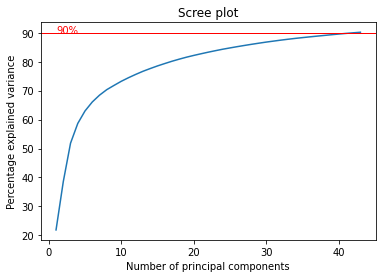

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [21]:
# PCA reduction, 90% variance explained 
pca = PCA(n_components=0.9, random_state=22)
pca.fit(my_feat)
x = pca.transform(my_feat)
print(x.shape)

# Scree plot
import matplotlib.pyplot as plt
scree = pca.explained_variance_ratio_*100
plt.plot(np.arange(len(scree))+1, scree.cumsum()) 
plt.xlabel("Number of principal components")
plt.ylabel("Percentage explained variance")
plt.axhline(90, lw=1, c='red')
plt.text(1, 90, '90%', c='red')
plt.title("Scree plot")
plt.show(block=False)

# t-SNE reduction
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=1)
tsne_results = tsne.fit_transform(x)

In [22]:
# Clustering
kmeans = KMeans(n_clusters=5, random_state=22)
kmeans.fit(tsne_results)            
y_pred =  kmeans.labels_

In [23]:
def visualization(tsne_results, y_pred):    
    # 2D visualization of y_pred and y_true
    fig = plt.figure(1, figsize=(20, 8))
    plt.suptitle("Cluster visualization", fontsize=25, fontweight='bold')

    # Plot 1
    plt.subplot(1, 2, 1)

    X_normalized = MinMaxScaler().fit_transform(tsne_results)
    data_array =  np.array(images.select("label").collect())
    # Reshape so that there are 1437 samples of 1280 vectors
    y_true = data_array.reshape(-1)
   

    cmap = plt.cm.get_cmap("jet")
    digits = np.unique(y_true)
    for i, digit in enumerate(digits):
        sns.scatterplot(X_normalized[y_true == digit, 0],
                        X_normalized[y_true == digit, 1],
                        c=[cmap(i / 5)],
                        label=digit)

    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.title("y_true", fontsize=15)

    # Plot 2
    plt.subplot(1, 2, 2)

    cmap = plt.cm.get_cmap("jet")
    digits = np.unique(y_pred)
    for i, digit in enumerate(digits):
        sns.scatterplot(X_normalized[y_pred == digit, 0],
                        X_normalized[y_pred == digit, 1],
                        c=[cmap(i / 5)],
                        label=digit)

    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.title("y_pred", fontsize=15)

    plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

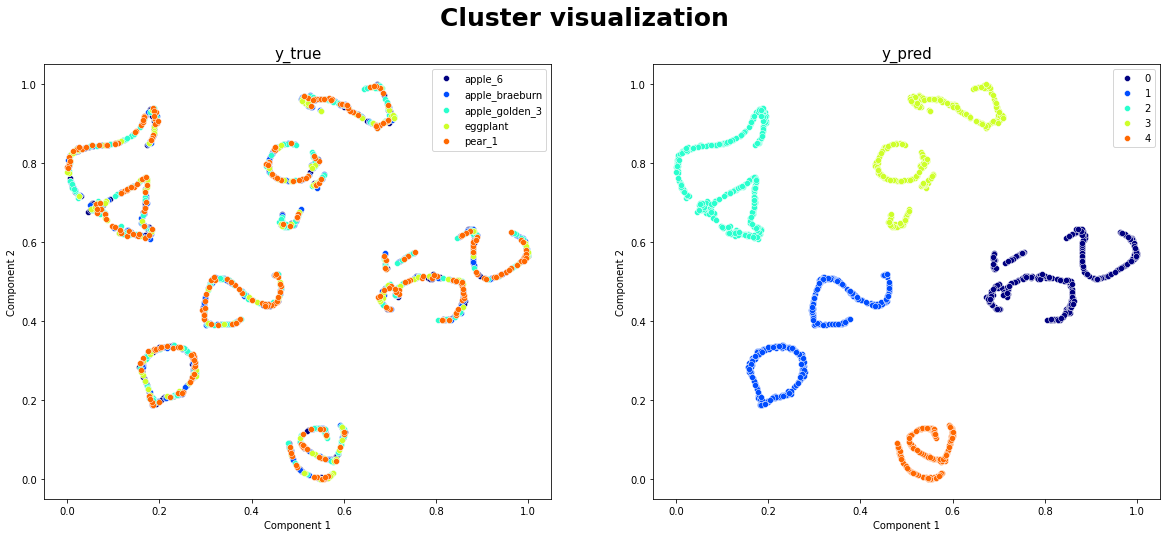

In [24]:
visualization(tsne_results, y_pred)

We notice that the model could not classify the images and this is explained by the fact that we did not use the last layer of the model.

# **II. Deployment of the solution in the cloud**

Now that we have verified that our solution works,
it's time to deploy it on a larger scale on a real cluster of machines.

I work under windows but I used an Ubuntu terminal,
the commands described below are therefore carried out
exclusively in this environment.

## **II.1. Technical choices :**

**Choice of cloud provider** : We are going to work with the most well-known service provider and which currently offers the offer
the largest in cloud computing which is Amazon Web Services (AWS).

The objective is to be able, thanks to AWS, to rent computing power on demand without increasing the cost too much.

**Choice of technical solution** : We chose the PAAS solution by choosing to use
Amazon Web Services' EMR service.
I find it more suited to our problem and allows
an implementation that is both faster and
more efficient than the IAAS solution.

**Choice of data storage solution** : We used the very effective solution for managing data storage: Amazon S3.
S3 for Amazon Simple Storage Service.

## **II.2. Setting up the working environment :**

At first, you have to install and configure AWS Cli (this is the command line interface of AWS).
It allows us to interact with the various AWS services, such as S3 for example.

To be able to use AWS Cli, it must be configured by first creating
a user who will be given the permissions we will need.
In this project, the user must have at least full control over the S3 service.

Users and their rights are managed via the AWS **AMI** service.

Once the user has been created and his permissions have been configured, we create a pair of keys
which will allow us to connect without having to systematically enter our login/password.

We must also configure SSH access to our future EC2 servers.
Here too, via a system of keys which exempts us from having to authenticate ourselves "by hand" at each connection.

All its configuration steps are perfectly described
in the course of the project: https://openclassrooms.com/fr/courses/4297166-realisez-des-calculs-distribues-sur-des-donnees-massives/4308686-decouvrez-amazon-web-services#/id/r-4355822

## **II.3. Upload data to S3 :**

Now we need to upload our data to Amazon S3. Here too the steps are precisely described in https://openclassrooms.com/fr/courses/4297166-realisez-des-calculs-distribues-sur-des-donnees-massives/4308691-stockez-des-donnees-sur-s3


## **II.4. Configuring the EMR server and creating the cluster :**

Once again, the course https://openclassrooms.com/fr/courses/4297166-realisez-des-calculs-distribues-sur-des-donnees-massives/4308696-deployez-un-cluster-de-calculs-distribues details the main steps
to launch a cluster with EMR.

## **II.5. Creating the SSH tunnel to the EC2 instance (Master)**

Now we will have to connect in SSH to the driver of our cluster. This step is also described in the course : https://openclassrooms.com/fr/courses/4297166-realisez-des-calculs-distribues-sur-des-donnees-massives/4308696-deployez-un-cluster-de-calculs-distribues#/id/r-4356512.

## **II.6. Code execution**

We decided to run this part of the code from JupyterHub hosted on our EMR cluster.





### **II.6.1. Starting the Spark session**

In [25]:
# Running this cell starts the Spark application

In [ ]:
%%info

ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
0,application_1653208661824_0001,pyspark,idle,Link,Link,None,✔


### **II.6.2.  Import of Librairies**

In [ ]:
import pandas as pd
import numpy as np
import io
import os
import tensorflow as tf
from PIL import Image
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras import Model
from pyspark.sql.functions import col, pandas_udf, PandasUDFType, element_at, split

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### **II.6.3. Defining PATHs**

In [ ]:
PATH = 's3://projet8-data'
PATH_Data = PATH+'/data_tot'
PATH_Result = PATH+'/Results'
print('PATH:        '+\
      PATH+'\nPATH_Data:   '+\
      PATH_Data+'\nPATH_Result: '+PATH_Result)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

PATH:        s3://projet8-data
PATH_Data:   s3://projet8-data/data_tot
PATH_Result: s3://projet8-data/Results

### **II.6.4. Data processing**

In [ ]:
images = spark.read.format("binaryFile") \
  .option("pathGlobFilter", "*.jpg") \
  .option("recursiveFileLookup", "true") \
  .load(PATH_Data)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
images.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-------------------+------+--------------------+
|                path|   modificationTime|length|             content|
+--------------------+-------------------+------+--------------------+
|s3://projet8-data...|2022-05-12 13:54:49|125373|[FF D8 FF E0 00 1...|
|s3://projet8-data...|2022-05-12 14:11:27|125135|[FF D8 FF E0 00 1...|
|s3://projet8-data...|2022-05-12 13:54:48|125088|[FF D8 FF E0 00 1...|
|s3://projet8-data...|2022-05-12 13:54:48|124905|[FF D8 FF E0 00 1...|
|s3://projet8-data...|2022-05-12 14:11:28|124785|[FF D8 FF E0 00 1...|
+--------------------+-------------------+------+--------------------+
only showing top 5 rows

In [ ]:
images = images.withColumn('label', element_at(split(images['path'], '/'),-2))
print(images.printSchema())
print(images.select('path','label').show(5,False))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- content: binary (nullable = true)
 |-- label: string (nullable = true)

None
+----------------------------------------------------------+-----------+
|path                                                      |label      |
+----------------------------------------------------------+-----------+
|s3://projet8-data/data_tot/Training/apple_hit_1/r0_116.jpg|apple_hit_1|
|s3://projet8-data/data_tot/test/apple_hit_1/r0_115.jpg    |apple_hit_1|
|s3://projet8-data/data_tot/Training/apple_hit_1/r0_114.jpg|apple_hit_1|
|s3://projet8-data/data_tot/Training/apple_hit_1/r0_108.jpg|apple_hit_1|
|s3://projet8-data/data_tot/test/apple_hit_1/r0_119.jpg    |apple_hit_1|
+----------------------------------------------------------+-----------+
only showing top 5 rows

None

In [ ]:
model = MobileNetV2(weights='imagenet',
                    include_top=True,
                    input_shape=(224, 224, 3))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

14540800/14536120 [==============================] - 0s 0us/step

In [ ]:
new_model = Model(inputs=model.input,
                  outputs=model.layers[-2].output)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
brodcast_weights = sc.broadcast(new_model.get_weights())

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
new_model.summary()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
____________________________________________________________________________________________

In [ ]:
def model_fn():
    """
    Returns a ResNet50 model with top layer removed 
    and broadcasted pretrained weights.
    """
    model = MobileNetV2(weights='imagenet',
                        include_top=True,
                        input_shape=(224, 224, 3))
   
    new_model = Model(inputs=model.input,
                  outputs=model.layers[-2].output)
    new_model.set_weights(brodcast_weights.value)
    return new_model

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
def preprocess(content):
    """
    Preprocesses raw image bytes for prediction.
    """
    img = Image.open(io.BytesIO(content)).resize([224, 224])
    arr = img_to_array(img)
    return preprocess_input(arr)

def featurize_series(model, content_series):
    """
    Featurize a pd.Series of raw images using the input model.
    :return: a pd.Series of image features
    """
    input = np.stack(content_series.map(preprocess))
    preds = model.predict(input)
    # For some layers, output features will be multi-dimensional tensors.
    # We flatten the feature tensors to vectors for easier storage in Spark DataFrames.
    output = [p.flatten() for p in preds]
    return pd.Series(output)

@pandas_udf('array<float>', PandasUDFType.SCALAR_ITER)
def featurize_udf(content_series_iter):
    '''
    This method is a Scalar Iterator pandas UDF wrapping our featurization function.
    The decorator specifies that this returns a Spark DataFrame column of type ArrayType(FloatType).

    :param content_series_iter: This argument is an iterator over batches of data, where each batch
                              is a pandas Series of image data.
    '''
    # With Scalar Iterator pandas UDFs, we can load the model once and then re-use it
    # for multiple data batches.  This amortizes the overhead of loading big models.
    model = model_fn()
    for content_series in content_series_iter:
        yield featurize_series(model, content_series)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
features_df = images.repartition(24).select(col("path"),
                                            col("label"),
                                            featurize_udf("content").alias("features")
                                           )

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
# Recording of processed data in "parquet" format
features_df.write.mode("overwrite").parquet(PATH_Result)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
# We load the freshly recorded data into a Pandas DataFrame
df = pd.read_parquet(PATH_Result, engine='pyarrow')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
df.head()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

                                                path  ...                                           features
0  s3://projet8-data/data_tot/test/apple_hit_1/r0...  ...  [0.40961775, 0.3664316, 1.8900975, 0.0, 0.0, 0...
1  s3://projet8-data/data_tot/test/apple_hit_1/r0...  ...  [0.18946813, 0.036795825, 2.1061482, 0.0, 0.03...
2  s3://projet8-data/data_tot/Training/apple_hit_...  ...  [0.17203553, 0.09680426, 1.2880942, 0.0, 0.480...
3  s3://projet8-data/data_tot/Validation/apple_hi...  ...  [0.95710063, 1.3251833, 1.1683486, 0.0, 1.0125...
4  s3://projet8-data/data_tot/Training/apple_hit_...  ...  [0.6444769, 0.19870156, 0.80646193, 0.0, 0.714...

[5 rows x 3 columns]

### **II.6.5. Saving results**

In [ ]:
# Saving results as csv
features_df.withColumn("path", col("path").cast("string"))\
           .withColumn("label", col("label").cast("string"))\
           .withColumn("features", col("features").cast("string"))\
           .coalesce(1)\
           .write.option("header","true")\
           .mode("Overwrite")\
           .csv(path=PATH_Result+"_CSV") 


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
# Reading the saved CSV
df = spark.read.format("csv").option("header","true").option("recursiveFileLookup", "true").load(PATH_Result+"_CSV")

df.show(truncate=20)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----------+--------------------+
|                path|      label|            features|
+--------------------+-----------+--------------------+
|s3://projet8-data...|apple_hit_1|[0.40961775, 0.36...|
|s3://projet8-data...|apple_hit_1|[0.18946813, 0.03...|
|s3://projet8-data...|apple_hit_1|[0.17203553, 0.09...|
|s3://projet8-data...|apple_hit_1|[0.95710063, 1.32...|
|s3://projet8-data...|apple_hit_1|[0.6444769, 0.198...|
|s3://projet8-data...|apple_hit_1|[0.46437255, 0.74...|
|s3://projet8-data...|apple_hit_1|[0.073995814, 1.0...|
|s3://projet8-data...|apple_hit_1|[0.064841926, 0.2...|
|s3://projet8-data...|apple_hit_1|[1.0522019, 0.214...|
|s3://projet8-data...|apple_hit_1|[0.12706788, 0.28...|
|s3://projet8-data...|apple_hit_1|[0.061663687, 0.1...|
|s3://projet8-data...|apple_hit_1|[0.079837315, 0.3...|
|s3://projet8-data...|apple_hit_1|[0.0, 0.33911982,...|
|s3://projet8-data...|apple_hit_1|[0.652857, 0.0014...|
|s3://projet8-data...|apple_hit_1|[0.07671988, 0